In [1]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [3]:
import gensim.downloader as api


fasttext = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [4]:
#!g1.1
import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [5]:
df = pd.read_csv('/kaggle/input/imdb-dataset/IMDB Dataset.csv')

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [7]:
#!g1.1
from torch.utils.data import Dataset


class IMDB(Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path)
        
        texts = self.df['review'].values

        self.vocab = Vocabulary(texts, min_freq=5)

        self.label2idx = {'positive': 0, 'negative': 1}

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

In [8]:
dataset = IMDB('/kaggle/input/imdb-dataset/IMDB Dataset.csv')

In [10]:
#!g1.1
from torch.utils.data import random_split


train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [11]:
#!g1.1
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

In [12]:
#!g1.1
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=1, 
                    out_channels=32, 
                    kernel_size=(fs, embedding_dim)) 
                for fs in [2, 3, 4, 5, 6]
            ]
        )

        self.batchnorms = nn.ModuleList(
            [
                nn.BatchNorm1d(32),
                nn.BatchNorm1d(32),
                nn.BatchNorm1d(32),
                nn.BatchNorm1d(32),
                nn.BatchNorm1d(32)
            ]
        )

        self.fc = nn.Linear(5 * 32, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        conv_results = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in conv_results]

        conv_results = [self.batchnorms[i](conv_results[i]) for i in range(len(conv_results))]

        x = self.dropout(torch.cat(conv_results, dim=1))

        return self.fc(x)


In [14]:
#!g1.1
vocab_size = len(dataset.vocab.vocabulary)
model = TextCNN(vocab_size=vocab_size+1, embedding_dim=25, pad_idx=pad_idx)

In [15]:
#!g1.1
from tqdm import tqdm


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model) -> float:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [16]:
#!g1.1
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [17]:
#!g1.1
from IPython.display import clear_output

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [22]:
#!g1.1
import matplotlib.pyplot as plt
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy.cpu())
        valid_accuracy_history.append(valid_accuracy.cpu())

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
    scheduler.step()

In [20]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

In [21]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cuda:0
Tesla P100-PCIE-16GB


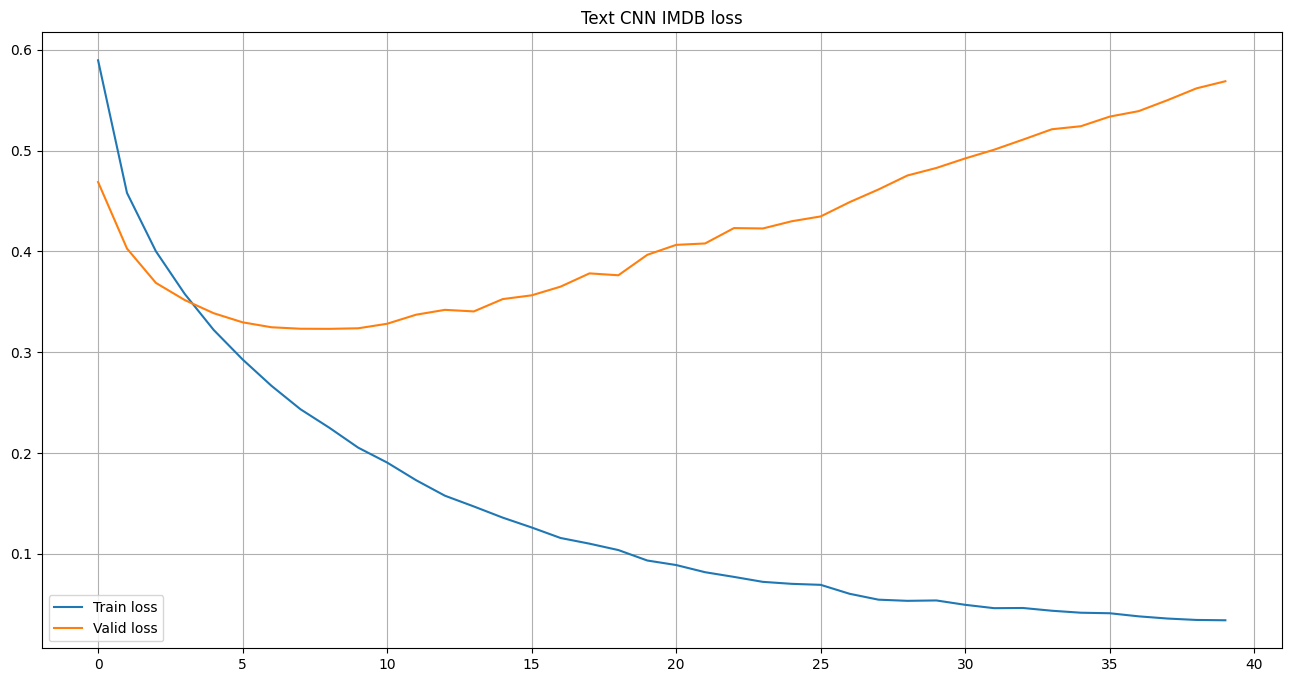

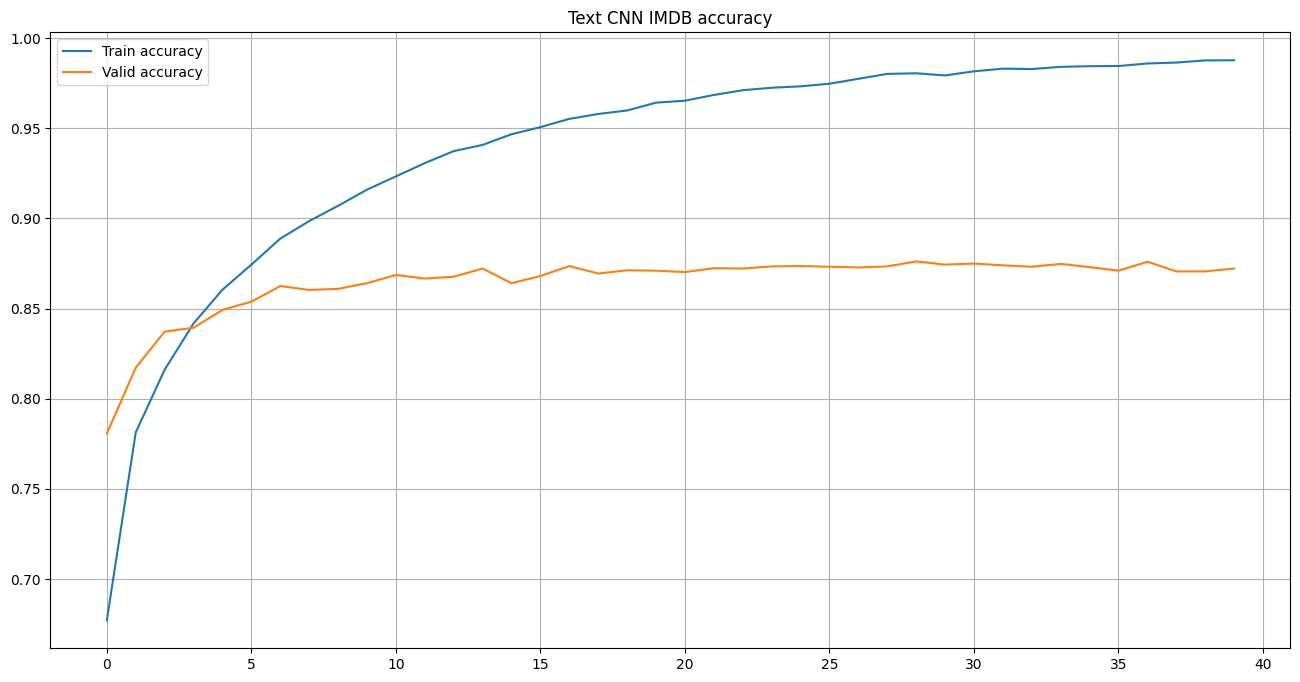

In [23]:
#!g1.1
from torch.optim.lr_scheduler import StepLR
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20)

whole_train_valid_cycle(model, 40, 'Text CNN IMDB')

In [24]:
predictions = []
model.eval()
with torch.no_grad():
    for text, label in test_loader:
        text, label = text.to(device), label.to(device)
        output = model(text)
        probabilities = torch.sigmoid(output)
        predicted_class = (probabilities > 0.5).int()
        predictions.extend(predicted_class.cpu().numpy())


predictions = torch.tensor(predictions)
predictions = predictions.squeeze()
torch.save(predictions, 'predictions.pt')


/tmp/ipykernel_34/212450996.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  predictions = torch.tensor(predictions)


In [25]:
predictions.shape

torch.Size([5000])